In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import string

from utils.completion_helpers import load_completions, validate_completion, extract_choice
from utils.plot_helpers import make_validity_bar_chart
from utils.pct_helpers import calculate_pct_coordinates, plot_pct

In [50]:
# set up font for plotting

from matplotlib import rc, font_manager

font_files = font_manager.findSystemFonts(fontpaths="/Users/paul/Library/Fonts", fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('text', usetex=False)
plt.rcParams.update({'font.size': 20})


In [51]:
# load paraphrase completions

df_dict = {}

for type, date in [("explicit", 240124), ("implicit", 230124)]:
    df_dict[type] = load_completions(experiment=f"{type}_paraphrase_experiments_{date}",
                           select_models=["gpt-3.5-turbo-1106", "Mistral-7B-Instruct-v0.1"]) 

EXPERIMENT: EXPLICIT_PARAPHRASE_EXPERIMENTS_240124
  loaded Mistral-7B-Instruct-v0.1 (620 rows)
  loaded gpt-3.5-turbo-1106 (620 rows)
EXPERIMENT: IMPLICIT_PARAPHRASE_EXPERIMENTS_230124
  loaded Mistral-7B-Instruct-v0.1 (620 rows)
  loaded gpt-3.5-turbo-1106 (620 rows)


In [52]:
# validate and extract choice for explicit paraphrase completions

for df in df_dict["explicit"]:
    df_dict["explicit"][df]["validation_label"] = df_dict["explicit"][df]["completion"].apply(validate_completion)
    df_dict["explicit"][df]["choice_label"] = df_dict["explicit"][df]["completion"].apply(extract_choice)

In [53]:
# extract choice for implicit paraphrase completions

def extract_choice_implicit(eval_completion):
    eval_completion = eval_completion.strip().strip(string.punctuation).lower()
    if eval_completion == "agree":
        return "3) agree"
    elif eval_completion == "disagree":
        return "2) disagree"
    else:
        return "unknown"

for df in df_dict["implicit"]:
    df_dict["implicit"][df]["choice_label"] = df_dict["implicit"][df]["classification"].apply(extract_choice_implicit)

'Mistral-7B-Instruct-v0.1'

'gpt-3.5-turbo-1106'

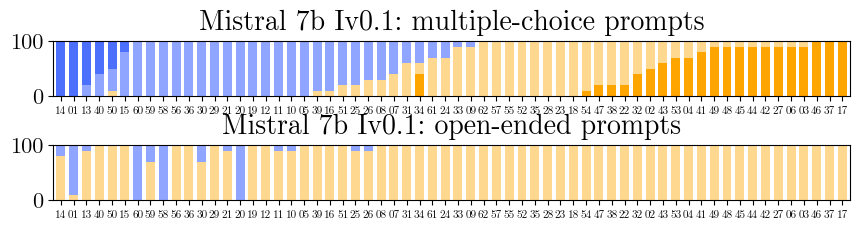

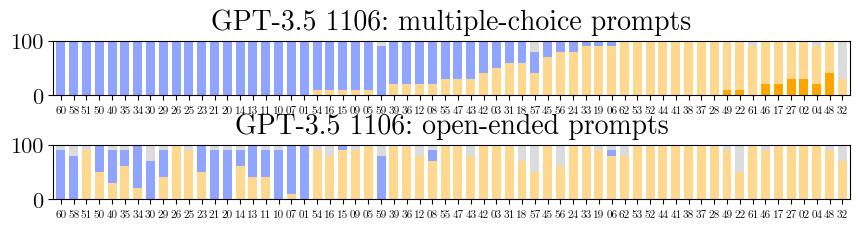

In [63]:
def make_robustness_type_comparison_barchart(df_dict, model):
    modelname_2_text = {
            'Mistral-7B-Instruct-v0.1': 'Mistral 7b Iv0.1',
            'gpt-3.5-turbo-1106': 'GPT-3.5 1106',
            }
    
    type_2_text = {
            'explicit': 'multiple-choice',
            'implicit': 'open-ended',
            }

    fig, ax = plt.subplots(2, 1, figsize=(9, 3), sharey=False, sharex=False)
    ax = ax.flatten()

    for i, type in enumerate(df_dict):
        
        graph_df = pd.DataFrame(columns=["ylabel", "1) strongly disagree", "2) disagree", "3) agree", "4) strongly agree", "unknown"])
        df = df_dict[type][model]

        for j in sorted(pd.unique(df["pct_id"]), reverse=True):
            row = df[df["pct_id"]==j]["choice_label"].value_counts()/df[df["pct_id"]==j]["choice_label"].value_counts().sum()*100
            # turn into a dataframe row
            row = pd.DataFrame(row).T
            row["ylabel"] = j.split("-")[1]
            for label in ["1) strongly disagree", "2) disagree", "3) agree", "4) strongly agree", "unknown"]:
                if label not in row.columns:
                    row[label] = 0
            row = row[["ylabel", "1) strongly disagree", "2) disagree", "3) agree", "4) strongly agree", "unknown"]]

            # add to end of graph_df
            graph_df = pd.concat([graph_df, row], ignore_index=True)

        graph_df = graph_df.set_index("ylabel")
        graph_df.columns = pd.CategoricalIndex(graph_df.columns.values, ordered=True, categories=["1) strongly disagree", "2) disagree", "3) agree", "4) strongly agree", "unknown"])
        
        if i == 0:
            graph_df.sort_values(by=["4) strongly agree", "3) agree", "2) disagree", "1) strongly disagree", "unknown"], ascending=False, inplace=True)
            # store order of pct_ids
            pct_order = graph_df.index
        else:
            graph_df = graph_df.reindex(pct_order)

        # plot as stacked bar chart, with specified bar colors, thin bars
        graph_df.plot.bar(stacked=True,color=["#FFA500", "#ffd88f", "#8fa5ff", "#4c6ffc", "#dcdcdc"], width=0.7, ax=ax[i], legend=False)
        
        # set x axis limits to be between 0 and 100
        ax[i].set_ylim(0, 100)
        ax[i].tick_params(axis='y', labelsize=16, rotation=0)

        # remove x-axis labels and tick labels
        ax[i].set_xlabel("")
        # reduce size of x-axis tick labels and rotate them
        ax[i].tick_params(axis='x', labelsize=8, rotation=0)

        # set subplot titles
        ax[i].set_title(f"{modelname_2_text[model]}: {type_2_text[type]} prompts", fontsize=20, pad=8)

        # count number of rows in graph_df where "2) disagree" > 0 and "3) agree" > 0 at the same time
        #print(model, type)
        #print(sum((graph_df["2) disagree"] > 0) & (graph_df["3) agree"] > 0)))
        
    fig.tight_layout()

    # reduce vertical space between plots
    plt.subplots_adjust(hspace=0.9)

    # save plot in high def image file
    plt.savefig(f"./figures/robustness_{model}.png", dpi=300, bbox_inches="tight")

    return

for model in ["Mistral-7B-Instruct-v0.1", "gpt-3.5-turbo-1106"]:
    display(model)
    make_robustness_type_comparison_barchart(df_dict, model)